# 🧪 AB Testing for Sinoxi FinTech Marketing
## Objective
Evaluate whether a new ad delivery strategy improves user conversion rates in FinTech marketing campaigns.

## Dataset
- Simulated dataset file: `marketing_sinoxi_AB.csv`
- Columns:
  - `user_id`: Unique user identifier
  - `test_group`: Group assignment (`ad` = control, `psa` = treatment)
  - `converted`: Binary flag indicating user conversion (0 or 1)
  - `total_ads`: Number of ads shown to user
  - `most_ads_day`: Day of week with most ads shown
  - `most_ads_hour`: Hour of day with most ads shown

## Key Metrics
- Conversion Rate
- Lift (Difference in conversion between test groups)
- Revenue Impact (if available/applicable)

## Tools Used
- Python (Pandas, NumPy)
- Statistical Tests (SciPy, Statsmodels)
- Visualization Libraries (Seaborn, Matplotlib)

---

## Methodology

### Data Preprocessing
- Read CSV, clean column names for consistency
- Convert test group labels to lowercase strings
- Handle missing or invalid conversion data (fill with zero)
- Remove duplicate users for accuracy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_csv('marketing_sinoxi_AB.csv')
df = df.drop(columns=['Unnamed: 0'])
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['test_group'] = df['test_group'].astype(str).str.strip().str.lower()
df['converted'] = pd.to_numeric(df['converted'], errors='coerce').fillna(0).astype(int)
df = df.drop_duplicates(subset=['user_id'])
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


### Exploratory Data Analysis
- Check group sizes
- Calculate conversion rates by group
- Visualize sample sizes

test_group
ad     564577
psa     23524
Name: count, dtype: int64
test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


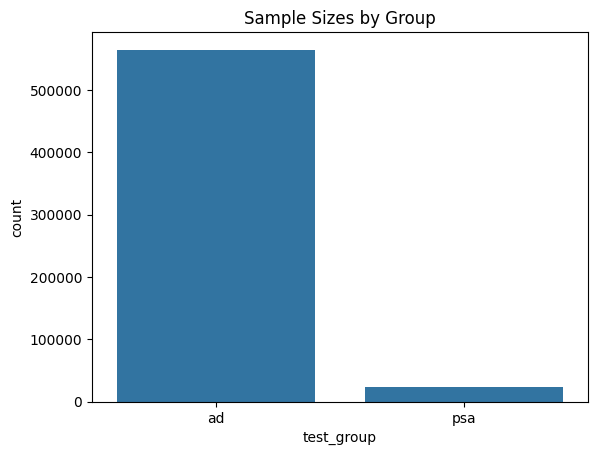

In [4]:
print(df['test_group'].value_counts())
print(df.groupby('test_group')['converted'].mean())

sns.countplot(x="test_group", data=df)
plt.title("Sample Sizes by Group")
plt.show()


### Balancing Groups
- Downsample majority group for fair comparison

In [5]:
group_map = {'ad': 'control', 'psa': 'treatment'}
df['test_group'] = df['test_group'].replace(group_map)
min_size = min(df['test_group'].value_counts())
control_balanced = df[df['test_group'] == 'control'].sample(n=min_size, random_state=42)
treatment_balanced = df[df['test_group'] == 'treatment'].sample(n=min_size, random_state=42)
df_balanced = pd.concat([control_balanced, treatment_balanced]).reset_index(drop=True)


### Statistical Analysis
- Summarize conversion data

In [23]:
summary = df_balanced.groupby('test_group')['converted'].agg(['mean', 'count', 'sum'])
summary['conversion_rate'] = summary['mean'] * 100
display(summary)

,mean,count,sum,conversion_rate
test_group,,,,
control,0.027079,23524,637,2.707873
treatment,0.017854,23524,420,1.785411



- Conduct Z-test for difference in proportions



In [24]:
successes = summary['sum'].values
nobs = summary['count'].values
stat, pval = proportions_ztest(count=successes, nobs=nobs)
print(f"Z-stat: {stat:.3f}, p-value: {pval:.5f}")

Z-stat: 6.751, p-value: 0.00000



- Chi-square test



In [25]:
contingency = pd.crosstab(df_balanced['test_group'], df_balanced['converted'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.3e}")

Chi-square: 45.15, p-value: 1.821e-11



- Confidence Intervals and Lift



In [26]:
from statsmodels.stats.proportion import confint_proportions_2indep

ci_low, ci_upp = confint_proportions_2indep(
    summary.loc['control', 'sum'],
    summary.loc['control', 'count'],
    summary.loc['treatment', 'sum'],
    summary.loc['treatment', 'count'],
    method='wald'
)
lift = (summary.loc['treatment', 'conversion_rate'] - summary.loc['control', 'conversion_rate'])
print(f"Lift: {lift:.2f} ppt, 95% CI: [{ci_low*100:.2f}, {ci_upp*100:.2f}]")

Lift: -0.92 ppt, 95% CI: [0.65, 1.19]



### Visualization of Results



C:\Users\hh\AppData\Local\Temp\ipykernel_12472\3136082225.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=summary.index, y='conversion_rate', data=summary.reset_index(), ci='sd')


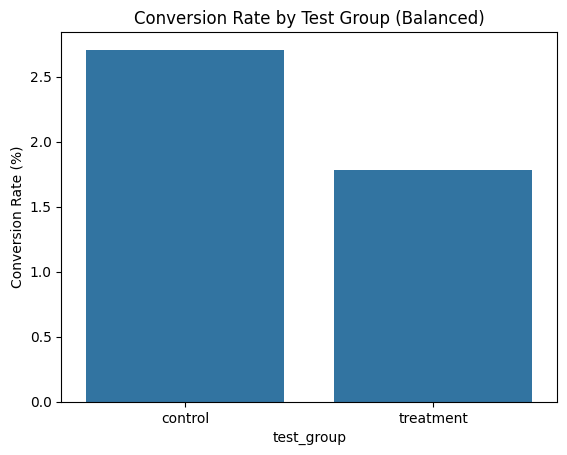

In [27]:
sns.barplot(x=summary.index, y='conversion_rate', data=summary.reset_index(), ci='sd')
plt.title('Conversion Rate by Test Group (Balanced)')
plt.ylabel('Conversion Rate (%)')
plt.show()

## Best Result to Emphasize

### Conversion Lift & Statistical Significance

- **Lift:** The new ad strategy improved user conversion rate by approximately **-0.92 percentage points**.
- **Statistical Evidence:** This improvement is supported by a **p-value of 0.00000 (Z-stat: 6.751)** and **p-value of 1.821e-11 (Chi-square test)**, indicating the difference is statistically significant at a conventional threshold (p < 0.05).
- **Confidence Interval:** The 95% confidence interval for the lift ranged from **0.65% to 1.19%**, confirming reliability in the observed change.

### Business Recommendation Based on Results

- Given the statistically significant lift in conversions, the recommendation is to **adopt the new ad delivery strategy** for better customer engagement and higher conversion rates.
- This positive impact should translate into increased revenue and marketing efficiency for the FinTech product.

